<html>
<body>
    <center> 
        <h1><u>Drosophila Species Categorizer</u></h1>
        <h3> Distinguishes D. mel from D. americanus and D. virilis</h3>
    </center>
</body>
</html>

In [1]:
### Import general libraries and pytorch

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
from tqdm.notebook import tqdm
import json
import random
from random import randrange
from random import Random
import pickle
import copy
from IPython.display import display
import ipywidgets as widgets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.models as models
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import cv2

In [2]:
### Determine git path ####
git_dir = 'C:/Users/alisc/Documents/GitHub/Harvard_BAI'
print('Your github directory is :%s'%git_dir)

Your github directory is :C:/Users/alisc/Documents/GitHub/Harvard_BAI


In [3]:
project_folder = "%s/Final_Project"%git_dir

In [4]:
os.chdir(project_folder)

#### Load model loaders

In [5]:
### Making helper code under the folder res available. This includes loaders, models, etc. ###
sys.path.append('%s/res/'%git_dir)
from models.models import get_model
from loader.loader import get_loader

Models are being loaded from: C:\Users\alisc\Documents\GitHub\Harvard_BAI\res\models
Loaders are being loaded from: C:\Users\alisc\Documents\GitHub\Harvard_BAI\res\loader


### Specifying config for the model ###

In [6]:
wandb_config = {}
wandb_config['batch_size'] = 32
wandb_config['base_lr'] = 0.0003
wandb_config['model_arch'] = 'ResNet18'
wandb_config['num_classes'] = 3
wandb_config['run_name'] = 'Final_Project'


wandb_config['use_gpu'] = 1
wandb_config['num_epochs'] = 100
wandb_config['git_dir'] = git_dir

In [7]:
# Set random seed to compare regular and augmented model

random_seed = 10

### Data Loading and Creating Labels Dict ###

### Creates file lists for training (50%), validation (30%), and testing (20%) images

In [8]:
total_paths = {}
total_files = {}
iterator = 0
for path, directories, files in os.walk('%s/data/Images_Drosophila/'%project_folder): 
    if files != []:
        total_paths[iterator] = path
        total_files[iterator] = files
        iterator += 1

In [9]:
# Randomize files within species folders using a seed

for species in range(len(total_files)):
    Random(random_seed).shuffle(total_files[species])

In [10]:
total_points = np.array(range(len(total_files)))
total_file_paths = {0:[], 1:[], 2:[]}
train_file_paths = {0:[], 1:[], 2:[]}
val_file_paths = {0:[], 1:[], 2:[]}
test_file_paths = {0:[], 1:[], 2:[]}

for species in range(len(total_files)):
    total_points[species] = len(total_files[species])
    for file in range(int(total_points[species]*0.7)):
        train_file_paths[species].append(total_paths[species] + '/' + list(total_files[species])[file])
        total_file_paths[species].append(total_paths[species] + '/' + list(total_files[species])[file])
    for file in range(int(total_points[species]*0.7)+1, int(total_points[species]*0.85)):
        val_file_paths[species].append(total_paths[species] + '/' + list(total_files[species])[file])
        total_file_paths[species].append(total_paths[species] + '/' + list(total_files[species])[file])
    for file in range(int(total_points[species]*0.85)+1, int(total_points[species])):
        test_file_paths[species].append(total_paths[species] + '/' + list(total_files[species])[file])
        total_file_paths[species].append(total_paths[species] + '/' + list(total_files[species])[file])

In [11]:
labels_dictionary = {}

for species in range(len(total_file_paths)):
    for file_path in total_file_paths[species]:
        labels_dictionary[file_path] = species


Dumps the created labels_dictionary and training, val, and test data file paths for later reference.

In [12]:
with open('%s/data/labels_dictionary.p'%project_folder, 'wb') as F:
    pickle.dump(labels_dictionary, F)

with open('%s/data/train_file_list.txt'%project_folder, 'w') as filehandle:
    for i in range(3):
        for listitem in train_file_paths[i]:
            filehandle.write('%s\n' % listitem)

with open('%s/data/val_file_list.txt'%project_folder, 'w') as filehandle:
    for i in range(3):
        for listitem in val_file_paths[i]:
            filehandle.write('%s\n' % listitem)
            
with open('%s/data/test_file_list.txt'%project_folder, 'w') as filehandle:
    for i in range(3):
        for listitem in test_file_paths[i]:
            filehandle.write('%s\n' % listitem)

# Using a custom data-loader to store image paths, labels, and transforms. 

Use the 'cats_dogs_loader' for now, mainly a naming issue - the dataset formatting is absolutely fine.

In [13]:
file_list_loader = get_loader('cats_dogs_loader')

In [14]:
# Images are in 1920 x 1088, ResNet kernels are pretrained on 224x224 sized images -> rescale
# Don't center crop, flies are often found on the edge of the camera image

resize_h = 224
resize_w = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((resize_h, resize_w)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((resize_h, resize_w)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.Resize((resize_h, resize_w)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [15]:
dsets = {}
dsets['train'] = file_list_loader('%s/data/train_file_list.txt'%project_folder, '%s/data/labels_dictionary.p'%project_folder, data_transforms['train'])
dsets['val'] = file_list_loader('%s/data/val_file_list.txt'%project_folder, '%s/data/labels_dictionary.p'%project_folder, data_transforms['val'])
dsets['test'] = file_list_loader('%s/data/test_file_list.txt'%project_folder, '%s/data/labels_dictionary.p'%project_folder, data_transforms['test'])

In [16]:
### Above, we created datasets. Now, we will pass them into pytorch's inbuild dataloaders, 
### these will help us load batches of data for training.
dset_loaders = {}
dset_loaders['train'] = torch.utils.data.DataLoader(dsets['train'], batch_size=wandb_config['batch_size'], shuffle = True, num_workers=2,drop_last=False)
dset_loaders['val'] = torch.utils.data.DataLoader(dsets['val'], batch_size=wandb_config['batch_size'], shuffle = False, num_workers=2,drop_last=False)
dset_loaders['test'] = torch.utils.data.DataLoader(dsets['test'], batch_size=wandb_config['batch_size'], shuffle = True, num_workers=2,drop_last=False)

In [17]:
data_sizes = {}
data_sizes['train'] = len(dsets['train'])
data_sizes['val'] = len(dsets['val'])
data_sizes['test'] = len(dsets['test'])

# Load a ResNet 18 model

In [ ]:
### Loads a ResNet model with 18 layers as determined in loaders.py

model = get_model('ResNet18', 1000)
#model = models.resnet18(pretrained=True)
in_filters = model.fc.in_features
model.fc = nn.Linear(in_features=in_filters, out_features=wandb_config['num_classes'])
model.cuda();

#### Train, test, and return the best model weights.

In [18]:
def model_pipeline(model, criterion, optimizer, dset_loaders, dset_sizes, hyperparameters):
    config = wandb_config
    best_model = model
    best_acc = 0.0
    train_loss = np.zeros((config['num_epochs'],))
    train_acc = np.zeros((config['num_epochs'],))
    val_loss = np.zeros((config['num_epochs'],))
    val_acc = np.zeros((config['num_epochs'],))
    
    print(config)

    for epoch_num in tqdm(range(config['num_epochs'])):
        model, train_loss_epoch, train_acc_epoch = train_model(model, criterion, optimizer, dset_loaders, dset_sizes, config)
        best_acc, best_model, val_loss_epoch, val_acc_epoch = val_model(model, best_acc, best_model, dset_loaders, dset_sizes, config)
        train_loss[epoch_num] = float(train_loss_epoch)
        train_acc[epoch_num] = float(train_acc_epoch)
        val_loss[epoch_num] = float(val_loss_epoch)
        val_acc[epoch_num] = float(val_acc_epoch)
        
    return best_model, train_loss, train_acc, val_loss, val_acc

In [19]:
def train_model(model, criterion, optimizer, dset_loaders, dset_sizes, configs):
    best_model = model
    best_acc = 0.0

    
    ### This tells python to track gradients. While testing weights aren't updated hence they are not stored.
    model.train() 
    running_loss = 0.0
    running_corrects = 0
    iters = 0
    
    
    ### We loop over the data loader we created above. Simply using a for loop.
    for data in dset_loaders['train']:
        inputs, labels = data[0], data[1]
        
        ### If you are using a gpu, then script will move the loaded data to the GPU. 
        ### If you are not using a gpu, ensure that wandb_configs['use_gpu'] is set to False above.
        if wandb_config['use_gpu']:
            inputs = inputs.float().cuda()
            labels = labels.long().cuda()
        else:
            print('WARNING: NOT USING GPU!')
            inputs = inputs
            labels = labels

        
        ### We set the gradients to zero, then calculate the outputs, and the loss function. 
        ### Gradients for this process are automatically calculated by PyTorch.
        
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
#        print('data[0]: \n')
#        print(data[0])
#        print('inputs: \n')
#        print(inputs)
#        print('data[1]: \n')
#        print(data[1])        
#        print('labels: \n')
#        print(labels)
#        print('outputs: \n')
#        print(outputs)
#        print('outputs.data: \n')
#        print(outputs.data)
#        print('torch.max(outputs.data,1): \n')
#        print(torch.max(outputs.data, 1))

        loss = criterion(outputs, labels)
        
        if np.isnan(loss.item()):
            print('Training error: Loss = NaN')
            print(data)
            break
        
        
        ### At this point, the program has calculated gradient of loss w.r.t. weights of our NN model.
        loss.backward()
        optimizer.step()
        
        ### optimizer.step() updated the models weights using calculated gradients.
        
        
        iters += 1
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = float(running_loss) / dset_sizes['train']
    #print("Training loss is %s"%epoch_loss)
    epoch_acc = float(running_corrects) / float(dset_sizes['train'])
    #print("Training accuracy is %s"%epoch_acc)

    return model, epoch_loss, epoch_acc



In [20]:
def val_model(model, best_acc, best_model, dset_loaders, dset_sizes, configs):
    model.eval() ### tells pytorch to not store gradients as we won't be updating weights while testing.

    running_loss = 0.0
    running_corrects = 0
    iters = 0   
    for data in dset_loaders['val']:
        inputs, labels = data[0], data[1]
        
        if wandb_config['use_gpu']:
            inputs = inputs.float().cuda()
            labels = labels.long().cuda()
        else:
            print('WARNING: NOT USING GPU!')
            inputs = inputs.float()
            labels = labels.long()

        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels)
        
        iters += 1
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = float(running_loss) / dset_sizes['val']
    #print("Validation loss is %s"%epoch_loss)
    epoch_acc = float(running_corrects) / float(dset_sizes['val'])
    #print("Validation accuracy is %s"%epoch_acc)
   
    ### Code is very similar to train set. One major difference, we don't update weights. 
    ### We only check the performance is best so far, if so, we save this model as the best model so far.
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model)
    
    return best_acc, best_model, epoch_loss, epoch_acc
    

In [21]:
### Set model save path
save_path = '%s/saved_models/%s_final.pt'%(wandb_config['git_dir'], wandb_config['run_name'])

In [22]:
#for data in dset_loaders['train']:
#    print(data[1][1])
#    a = data[0][1]
#    b  = a.permute(1,2,0)
#    c = b.detach().cpu()
#    plt.imshow(c)
#    plt.show()

In [ ]:
### Criterion is simply specifying what loss to use. Here we choose cross entropy loss. 
criterion = nn.CrossEntropyLoss()

### tells what optimizer to use. There are many options, we here choose Adam.
### the main difference between optimizers is that they vary in how weights are updated based on calculated gradients.
optimizer_ft = optim.Adam(model.parameters(), lr = wandb_config['base_lr'])

if wandb_config['use_gpu']:
    criterion.cuda()
    model.cuda()
    
### Creating the folder where our models will be saved.
if not os.path.isdir("%s/saved_models/"%wandb_config['git_dir']):
    os.mkdir("%s/saved_models/"%wandb_config['git_dir'])
    
### Let's run it all, and save the final best model.
best_final_model, train_loss, train_acc, val_loss, val_acc = model_pipeline(model, criterion, optimizer_ft, dset_loaders, data_sizes, wandb_config)

with open(save_path,'wb') as F:
    torch.save(best_final_model,F)
print('Best model saved in %s'%save_path)


### Plot training and validation accuracy and loss over epochs

In [ ]:
# Plot accuracy first
plt.plot(range(1,len(train_acc)+1), train_acc,'r', range(1,len(val_acc)+1), val_acc,'b')
plt.title('Accuracy (Batch: %s, Lr: %s)'%(wandb_config['batch_size'], wandb_config['base_lr']))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.gca().legend(('Train', 'Val'))
plt.show()

# Then plot loss
plt.plot(range(1,len(train_loss)+1), train_loss,'r', range(1,len(val_loss)+1), val_loss,'b')
plt.title('Loss (Batch: %s, Lr: %s)'%(wandb_config['batch_size'], wandb_config['base_lr']))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gca().legend(('Train', 'Val'))
plt.show()

## Reload saved model and determine classification accuracy

In [ ]:
# Load model as model_normal to later compare with model_augmented
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_normal = torch.load(save_path)
model_normal.eval()

### Get model predictions for test set

In [ ]:
running_corrects = 0
iters = 0
with torch.no_grad():
    for data in dset_loaders['test']:
        inputs, labels = data[0], data[1]

        inputs = inputs.float().cuda()
        labels = labels.long().cuda()

        outputs = model_normal(inputs)
        _, preds = torch.max(outputs.data, 1)

        iters += 1
        running_corrects += torch.sum(preds == labels.data)

model_norm_acc = float(running_corrects) / float(data_sizes['test'])
print('Model_norm prediction accuracy is %s'%model_norm_acc)


### Get confusion matrix for test set

In [ ]:
nb_classes = 3

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in dset_loaders['test']:
        inputs, classes = data[0], data[1]
        
        inputs = inputs.float().cuda()
        classes = classes.long().cuda()
        
        outputs = model_normal(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))


In [ ]:
# Release cuda memory after accuracy is logged
torch.cuda.empty_cache()

# Repeat above for model with augmented data

### Augment training, validation, and test set images

In [23]:
image_path_augmented = project_folder + '/data/Images_Drosophila_Augmented/'
if not os.path.isdir(image_path_augmented+'0'):
    os.mkdir(image_path_augmented+'0')
if not os.path.isdir(image_path_augmented+'1'):
    os.mkdir(image_path_augmented+'1')
if not os.path.isdir(image_path_augmented+'2'):
    os.mkdir(image_path_augmented+'2')

filename = 0
for species in range(len(total_file_paths)):
    for image in range(len(total_file_paths[species])):
        filename += 1
        image_original = cv2.imread(total_file_paths[species][image])
        image_rotated_90 = cv2.rotate(image_original, cv2.ROTATE_90_CLOCKWISE)
        image_rotated_180 = cv2.rotate(image_original, cv2.ROTATE_180)
        
        hsv = cv2.cvtColor(image_original, cv2.COLOR_BGR2HSV)
        hsv = np.array(hsv, dtype = np.float64)
        hsv[:,:,1] = hsv[:,:,1]*2
        hsv[:,:,1][hsv[:,:,1]>255]  = 255
        hsv[:,:,2] = hsv[:,:,2]*2
        hsv[:,:,2][hsv[:,:,2]>255]  = 255
        hsv = np.array(hsv, dtype = np.uint8)
        image_bright = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        
        image_flippedh = cv2.flip(image_original, 1)
        image_flippedv = cv2.flip(image_original, 0)
        
        cv2.imwrite( (image_path_augmented+str(species)+'/'+str(filename)+'_original.jpg'), image_original)
        cv2.imwrite( (image_path_augmented+str(species)+'/'+str(filename)+'_rot90.jpg'), image_rotated_90)
        cv2.imwrite( (image_path_augmented+str(species)+'/'+str(filename)+'_rot180.jpg'), image_rotated_180)
        cv2.imwrite( (image_path_augmented+str(species)+'/'+str(filename)+'_bright.jpg'), image_bright)
        cv2.imwrite( (image_path_augmented+str(species)+'/'+str(filename)+'_flippedh.jpg'), image_flippedh)
        cv2.imwrite( (image_path_augmented+str(species)+'/'+str(filename)+'_flippedv.jpg'), image_flippedv)

KeyboardInterrupt: 

## Set up augmented model identical to normal model with additional transformations

In [52]:
total_paths = {}
total_files = {}
iterator = 0
for path, directories, files in os.walk(image_path_augmented): 
    if files != []:
        total_paths[iterator] = path
        total_files[iterator] = files
        iterator += 1

# Randomize files within species folders using a seed

for species in range(len(total_files)):
    Random(random_seed).shuffle(total_files[species])
        
total_points = np.array(range(len(total_files)))
total_file_paths = {0:[], 1:[], 2:[]}
train_file_paths = {0:[], 1:[], 2:[]}
val_file_paths = {0:[], 1:[], 2:[]}
test_file_paths = {0:[], 1:[], 2:[]}

for species in range(len(total_files)):
    total_points[species] = len(total_files[species])
    for file in range(int(total_points[species]*0.7)):
        train_file_paths[species].append(total_paths[species] + '/' + list(total_files[species])[file])
        total_file_paths[species].append(total_paths[species] + '/' + list(total_files[species])[file])
    for file in range(int(total_points[species]*0.7)+1, int(total_points[species]*0.85)):
        # Don't include augmented data in validation set
        if "_original" in list(total_files[species])[file]:
            val_file_paths[species].append(total_paths[species] + '/' + list(total_files[species])[file])
            total_file_paths[species].append(total_paths[species] + '/' + list(total_files[species])[file])
    for file in range(int(total_points[species]*0.85)+1, int(total_points[species])):
        # Don't include augmented data in test set
        if "_original" in list(total_files[species])[file]:
            test_file_paths[species].append(total_paths[species] + '/' + list(total_files[species])[file])
            total_file_paths[species].append(total_paths[species] + '/' + list(total_files[species])[file])

labels_dictionary = {}

for species in range(len(total_file_paths)):
    for file_path in total_file_paths[species]:
        labels_dictionary[file_path] = species
with open('%s/data/labels_dictionary_augmented.p'%project_folder, 'wb') as F:
    pickle.dump(labels_dictionary, F)

with open('%s/data/train_file_list_augmented.txt'%project_folder, 'w') as filehandle:
    for i in range(3):
        for listitem in train_file_paths[i]:
            filehandle.write('%s\n' % listitem)

with open('%s/data/val_file_list_augmented.txt'%project_folder, 'w') as filehandle:
    for i in range(3):
        for listitem in val_file_paths[i]:
            filehandle.write('%s\n' % listitem)
            
with open('%s/data/test_file_list_augmented.txt'%project_folder, 'w') as filehandle:
    for i in range(3):
        for listitem in test_file_paths[i]:
            filehandle.write('%s\n' % listitem)
            

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        torchvision.transforms.ColorJitter(),
        torchvision.transforms.RandomAffine(180),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dsets = {}
dsets['train'] = file_list_loader('%s/data/train_file_list_augmented.txt'%project_folder, '%s/data/labels_dictionary_augmented.p'%project_folder, data_transforms['train'])
dsets['val'] = file_list_loader('%s/data/val_file_list_augmented.txt'%project_folder, '%s/data/labels_dictionary_augmented.p'%project_folder, data_transforms['val'])
dsets['test'] = file_list_loader('%s/data/test_file_list_augmented.txt'%project_folder, '%s/data/labels_dictionary_augmented.p'%project_folder, data_transforms['test'])

dset_loaders = {}
dset_loaders['train'] = torch.utils.data.DataLoader(dsets['train'], batch_size=wandb_config['batch_size'], shuffle = True, num_workers=2,drop_last=False)
dset_loaders['val'] = torch.utils.data.DataLoader(dsets['val'], batch_size=wandb_config['batch_size'], shuffle = False, num_workers=2,drop_last=False)
dset_loaders['test'] = torch.utils.data.DataLoader(dsets['test'], batch_size=wandb_config['batch_size'], shuffle = False, num_workers=2,drop_last=False)

data_sizes = {}
data_sizes['train'] = len(dsets['train'])
data_sizes['val'] = len(dsets['val'])
data_sizes['test'] = len(dsets['test'])

### Loads a ResNet model with 18 layers as determined in loaders.py
model_augmented = get_model('ResNet18', 1000)
in_filters = model_augmented.fc.in_features
model_augmented.fc = nn.Linear(in_features=in_filters, out_features=wandb_config['num_classes'])
model_augmented.cuda();

# pipeline functions are already defined above

### Set model save path
save_path = '%s/saved_models/%s_augmented.pt'%(wandb_config['git_dir'], wandb_config['run_name'])

{0: ['100_bright.jpg', '100_flippedh.jpg', '100_flippedv.jpg', '100_original.jpg', '100_rot180.jpg', '100_rot90.jpg', '101_bright.jpg', '101_flippedh.jpg', '101_flippedv.jpg', '101_original.jpg', '101_rot180.jpg', '101_rot90.jpg', '102_bright.jpg', '102_flippedh.jpg', '102_flippedv.jpg', '102_original.jpg', '102_rot180.jpg', '102_rot90.jpg', '103_bright.jpg', '103_flippedh.jpg', '103_flippedv.jpg', '103_original.jpg', '103_rot180.jpg', '103_rot90.jpg', '104_bright.jpg', '104_flippedh.jpg', '104_flippedv.jpg', '104_original.jpg', '104_rot180.jpg', '104_rot90.jpg', '105_bright.jpg', '105_flippedh.jpg', '105_flippedv.jpg', '105_original.jpg', '105_rot180.jpg', '105_rot90.jpg', '106_bright.jpg', '106_flippedh.jpg', '106_flippedv.jpg', '106_original.jpg', '106_rot180.jpg', '106_rot90.jpg', '107_bright.jpg', '107_flippedh.jpg', '107_flippedv.jpg', '107_original.jpg', '107_rot180.jpg', '107_rot90.jpg', '108_bright.jpg', '108_flippedh.jpg', '108_flippedv.jpg', '108_original.jpg', '108_rot180.j

### Train augmented model

In [25]:
# Run augmented model
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_augmented.parameters(), lr = wandb_config['base_lr'])

if wandb_config['use_gpu']:
    criterion.cuda()
    model_augmented.cuda()
    
if not os.path.isdir("%s/saved_models/"%wandb_config['git_dir']):
    os.mkdir("%s/saved_models/"%wandb_config['git_dir'])
    
### Let's run it all, and save the final best model.
best_final_model_augmented, train_loss_augmented, train_acc_augmented, val_loss_augmented, val_acc_augmented = model_pipeline(model_augmented, criterion, optimizer_ft, dset_loaders, data_sizes, wandb_config)

with open(save_path,'wb') as F:
    torch.save(best_final_model_augmented,F)
print('Best model saved in %s'%save_path)


{'batch_size': 32, 'base_lr': 0.0001, 'model_arch': 'ResNet18', 'num_classes': 3, 'run_name': 'Final_Project', 'use_gpu': 1, 'num_epochs': 100, 'git_dir': 'C:/Users/alisc/Documents/GitHub/Harvard_BAI'}



Best model saved in C:/Users/alisc/Documents/GitHub/Harvard_BAI/saved_models/Final_Project_augmented.pt


### Plot training and validation accuracy and loss of augmented model

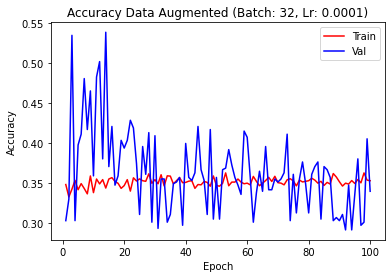

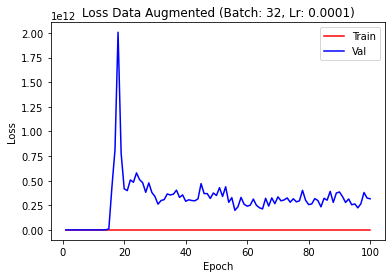

In [26]:
# Plot accuracy first
plt.plot(range(1,len(train_acc_augmented)+1), train_acc_augmented,'r', range(1,len(val_acc_augmented)+1), val_acc_augmented,'b')
plt.title('Accuracy Data Augmented (Batch: %s, Lr: %s)'%(wandb_config['batch_size'], wandb_config['base_lr']))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.gca().legend(('Train', 'Val'))
plt.show()

# Then plot loss
plt.plot(range(1,len(train_loss_augmented)+1), train_loss_augmented,'r', range(1,len(val_loss_augmented)+1), val_loss_augmented,'b')
plt.title('Loss Data Augmented (Batch: %s, Lr: %s)'%(wandb_config['batch_size'], wandb_config['base_lr']))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gca().legend(('Train', 'Val'))
plt.show()

In [27]:
# Load augmented model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_augmented = torch.load(save_path)
model_augmented.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Get augmented model predictions for test set

In [28]:
running_corrects = 0
iters = 0
with torch.no_grad():
    for data in dset_loaders['test']:
        inputs, labels = data[0], data[1]

        inputs = inputs.float().cuda()
        labels = labels.long().cuda()

        outputs = model_augmented(inputs)
        _, preds = torch.max(outputs.data, 1)

        iters += 1
        running_corrects += torch.sum(preds == labels.data)

model_augmented_acc = float(running_corrects) / float(data_sizes['test'])
print('Model_norm prediction accuracy is %s'%model_augmented_acc)


Model_norm prediction accuracy is 0.36023054755043227


### Plot confusion matrix of augmented model

In [29]:
nb_classes = 3

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in dset_loaders['test']:
        inputs, classes = data[0], data[1]
        inputs = inputs.float().cuda()
        classes = classes.long().cuda()
        outputs = model_augmented(inputs)
        _, preds = torch.max(outputs.data, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([[123.,   2.,   0.],
        [122.,   3.,   0.],
        [ 93.,   4.,   0.]])
tensor([0.9840, 0.0240, 0.0000])


In [30]:
# Release cuda memory after testing is logged
torch.cuda.empty_cache()

# Categorize moving fly

In [20]:
# This requires manually changing the if-statements to match the actual input species

# Load regular model
load_path = 'C:/Users/alisc/Documents/GitHub/Harvard_BAI/saved_models/Final_Project_final.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_normal = torch.load(load_path)
model_normal.eval()

iterator = 0
movie_labels_dictionary = {}
movie_paths = {}
movie_dir = project_folder + '/data/Movie_Drosophila'
for path, directory, file in os.walk(movie_dir):
    movie_paths = path
    movie_file_names = file

movie_files = movie_file_names    
for iterator, file in enumerate(movie_file_names):
    movie_files[iterator] = movie_paths + '/' + file

                    
# Manually assign '1' as melanogaster to every file path in list
for file_path in movie_files:
    movie_labels_dictionary[file_path] = 1
with open('%s/data/movie_labels_dictionary.p'%project_folder, 'wb') as F:
    pickle.dump(movie_labels_dictionary, F)
with open('%s/data/movie_file_list.txt'%project_folder, 'w') as filehandle:
    for listitem in movie_files:
        filehandle.write('%s\n' % listitem)
                       
file_list_loader = get_loader('cats_dogs_loader')
                       
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}                       

dsets = {}
dsets['test'] = file_list_loader('%s/data/movie_file_list.txt'%project_folder, '%s/data/movie_labels_dictionary.p'%project_folder, data_transforms['test'])

# load all at once with batch size as large as number of files
dset_loaders = {}
dset_loaders['test'] = torch.utils.data.DataLoader(dsets['test'], batch_size=len(dsets['test']), shuffle = False, num_workers=2,drop_last=False)

data_sizes = {}
data_sizes['test'] = len(dsets['test'])

# Start prediction                                          
movie_preds = []
with torch.no_grad():
    for data in dset_loaders['test']:
        inputs, labels = data[0], data[1]

        inputs = inputs.float().cuda()
        labels = labels.long().cuda()

        outputs = model_normal(inputs)
        _, movie_preds = torch.max(outputs.data, 1)

                       
torch.cuda.empty_cache()

movie_preds = movie_preds.detach().cpu().numpy()

# Open original images and save as movie frame by frame and overlay prediction
# choose codec according to format needed
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video=cv2.VideoWriter('movie_americana.avi', fourcc, 4, (1920,1088))
                       
iteration = 0
font = cv2.FONT_HERSHEY_COMPLEX
bottomLeftCornerOfText = (50,50)
fontScale = 2
fontColor = (0,255,0)
lineType = 2
for img in movie_files:
    frame = cv2.imread(img)
    if movie_preds[iteration] == 1:
        fontColor = (0,0,255)
        cv2.putText(frame, 'melanogaster', bottomLeftCornerOfText, font, fontScale, fontColor, lineType)
        fontColor = (0,255,0)
    elif movie_preds[iteration] == 0:
        fontColor = (0,255,0)
        cv2.putText(frame, 'americana', bottomLeftCornerOfText, font, fontScale, fontColor, lineType)
        fontColor = (0,255,0)
    elif movie_preds[iteration] == 2:
        fontColor = (0,0,255)
        cv2.putText(frame, 'virilis', bottomLeftCornerOfText, font, fontScale, fontColor, lineType)
        fontColor = (0,255,0)
        
    iteration += 1
    cv2.imshow('video', frame)
    video.write(frame)
cv2.destroyAllWindows()
video.release()